# Uplift modelling

An complex example of how heterogeneous treatment effects are used in ecommerce platforms. 🚀🚀🚀

**The business problem:**

We are concerted with *giving or not giving users a 5% discount voucher*.

If we give it to everyone, we'll likely get more bookings, but at the same time we hurt our margins. So the best way to proceed is to give the coupons only to those customers that were unsure about the decision and that will actually convert after receiving it. Also, not giving the coupons to customers that were already going to book something no matter what!

**The causal problem:**

Our treatment $T$ is offering customers this coupon, a binary variable.

Our outcome $Y$ is the customer finalizing their booking or not, also a binary variable.

Additionally, we have access to a number of other variables $X$ characterizing the user, the channel that brough them to the platform, the specific ongoing session, and so on... We believe some of them could be valuable in deciding the effectiveness of the intervention. In other words, the effect isn't uniform but varies depending on some of these factors.

In [15]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from uplift_modelling_utils import binned_validation, data_generating_process, uplift_curve

np.random.seed(111)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.plotting_context("talk", font_scale=1.2)

{'axes.linewidth': 1.875,
 'grid.linewidth': 1.5,
 'lines.linewidth': 2.25,
 'lines.markersize': 9.0,
 'patch.linewidth': 1.5,
 'xtick.major.width': 1.875,
 'ytick.major.width': 1.875,
 'xtick.minor.width': 1.5,
 'ytick.minor.width': 1.5,
 'xtick.major.size': 9.0,
 'ytick.major.size': 9.0,
 'xtick.minor.size': 6.0,
 'ytick.minor.size': 6.0,
 'font.size': 21.599999999999998,
 'axes.labelsize': 21.599999999999998,
 'axes.titlesize': 21.599999999999998,
 'xtick.labelsize': 19.8,
 'ytick.labelsize': 19.8,
 'legend.fontsize': 19.8,
 'legend.title_fontsize': 21.599999999999998}

### Collect data and check basic properties

The `data_generating_process` function returns the `data` itself, which can be used to train models. It also returns `metadata`, which is NOT available in practice, but which we can explore here to assess model performance exactly.

We draw 60000 samples and see that there seems to be a difference in the booking probability when offering customers a coupon.

In [3]:
# Observational (targeted / unbalanced)
data, metadata = data_generating_process(10000, setting="observational")
data.head()

,client_id,Y,T,true_uplift,channel,device,lead_time,funnel_depth,price_sort_used,past_coupon_user,tenure_days,dest_tier,hour_local,recent_ad_exposure
0,0,0,1,0.021592,email,app,10,0,0,1,330,tier1,4,0
1,1,0,1,0.106527,paid_search,mobile_web,1,2,1,0,484,tier2,8,1
2,2,1,1,0.047302,paid_search,desktop,45,0,0,1,550,tier1,18,1
3,3,0,0,0.208730,paid_search,desktop,60,2,1,0,585,tier2,22,0
4,4,1,1,0.067899,paid_search,app,3,1,1,1,665,tier2,20,1


In [4]:
# Quick sanity checks
print("Dataset:")
print(" n =", len(data))
print(" treat_rate =", data["T"].mean().round(4))
print(" conv_rate_T1 =", data.loc[data["T"] == 1, "Y"].mean().round(4))
print(" conv_rate_T0 =", data.loc[data["T"] == 0, "Y"].mean().round(4))
print(" ATE (naive) =", (data.loc[data["T"] == 1, "Y"].mean() - data.loc[data["T"] == 0, "Y"].mean()).round(4))


Dataset:
 n = 10000
 treat_rate = 0.5803
 conv_rate_T1 = 0.1675
 conv_rate_T0 = 0.1156
 ATE (naive) = 0.0519


In [5]:
# One hot encode "channel" and "device"
data = pd.get_dummies(data, columns=["channel", "device"], drop_first=True, dtype=int)
# Ordinal encode "dest_tier"
data.loc[:, "dest_tier"] = data["dest_tier"].map({"tier1": 1, "tier2": 2, "tier3": 3})

data

,client_id,Y,T,true_uplift,lead_time,funnel_depth,price_sort_used,past_coupon_user,tenure_days,dest_tier,hour_local,recent_ad_exposure,channel_direct,channel_email,channel_organic,channel_paid_search,device_desktop,device_mobile_web
0,0,0,1,0.021592,10,0,0,1,330,1,4,0,0,1,0,0,0,0
1,1,0,1,0.106527,1,2,1,0,484,2,8,1,0,0,0,1,0,1
2,2,1,1,0.047302,45,0,0,1,550,1,18,1,0,0,0,1,1,0
3,3,0,0,0.208730,60,2,1,0,585,2,22,0,0,0,0,1,1,0
4,4,1,1,0.067899,3,1,1,1,665,2,20,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,1,0.034795,30,0,0,1,611,1,16,0,0,0,0,1,0,1
9996,9996,0,0,0.002015,45,2,0,1,885,2,14,0,0,0,1,0,1,0
9997,9997,0,0,0.014063,45,1,0,1,1251,3,22,0,0,0,1,0,0,1
9998,9998,0,0,0.083331,21,3,1,1,154,1,10,0,0,0,1,0,1,0


In [6]:
def train_test_split_df(df: pd.DataFrame, features: list, test_size=0.25, seed=123):
    x = df[features].values
    y = df["Y"].astype(float).values
    t = df["T"].astype(float).values
    u = df["true_uplift"].astype(float).values
    return train_test_split(x, y, t, u, test_size=test_size, random_state=seed, stratify=t)


X_train, X_test, y_train, y_test, t_train, t_test, u_train, u_test = train_test_split_df(
    data,
    features=[col for col in data.columns if col not in ["client_id", "Y", "T", "true_uplift"]],
    test_size=0.25,
)

All learners map $R_x$ to $R$, a set of features $x$ to the predicted uplift, a continuous scalar value.

In [7]:
class TLearner:
    """A simple T-Learner implementation."""

    def __init__(self, model_factory=lambda: GradientBoostingClassifier(random_state=7)) -> None:
        """Specify the model class (factory) to be used for the two models."""
        self.m1 = model_factory()
        self.m0 = model_factory()

    def fit(self, x: np.ndarray, t: np.ndarray, y: np.ndarray) -> None:
        """Fit the control and treatment models."""
        self.m1.fit(x[t == 1], y[t == 1])
        self.m0.fit(x[t == 0], y[t == 0])

    def predict_uplift(self, x: np.ndarray) -> np.ndarray:
        """Predict the uplift (treatment effect) for each sample in x."""
        p1 = self.m1.predict_proba(x)[:, 1]
        p0 = self.m0.predict_proba(x)[:, 1]
        return p1 - p0

# T-learner
t_learner = TLearner()
t_learner.fit(X_train, t_train, y_train)

In [10]:
class XLearner:
    """A simple X-Learner implementation."""

    def __init__(
        self,
        clf_factory=lambda: GradientBoostingClassifier(random_state=7),
        reg_factory=lambda: GradientBoostingRegressor(random_state=7),
        prop_factory=lambda: LogisticRegression(max_iter=300),
    ) -> None:
        """Specify the model classes (factories) to be used."""
        self.m1 = clf_factory()
        self.m0 = clf_factory()
        self.g1 = reg_factory()
        self.g0 = reg_factory()
        self.prop = prop_factory()

    def fit(self, x: np.ndarray, t: np.ndarray, y: np.ndarray) -> None:
        """Fit the two outcome models, the two treatment effect models, and the propensity model."""
        self.m1.fit(x[t == 1], y[t == 1])
        self.m0.fit(x[t == 0], y[t == 0])
        
        # Estimate unobserved counterfactuals
        y1_t1 = y[t == 1]
        y0_t1 = self.m0.predict_proba(x[t == 1])[:, 1]
        tau_t1 = y1_t1 - y0_t1  
        
        y0_t0 = y[t == 0]
        y1_t0 = self.m1.predict_proba(x[t == 0])[:, 1]
        tau_t0 = y1_t0 - y0_t0 

        self.g1.fit(x[t == 1], tau_t1)
        self.g0.fit(x[t == 0], tau_t0)

        self.prop.fit(x, t)

    def predict_uplift(self, x: np.ndarray) -> np.ndarray:
        """Predict the uplift for a given set of features."""
        e = np.clip(self.prop.predict_proba(x)[:, 1], 1e-3, 1 - 1e-3)
        tau1 = self.g1.predict(x)
        tau0 = self.g0.predict(x)
        return e * tau0 + (1.0 - e) * tau1
    
x_learner = XLearner()
x_learner.fit(X_train, t_train, y_train)

In [12]:
# Predict uplift on test

tau_T = t_learner.predict_uplift(X_test)
tau_X = x_learner.predict_uplift(X_test)

uplift = pd.DataFrame(
    {
        "u_true": u_test,
        "tau_T": tau_T,
        "tau_X": tau_X,
    }
)

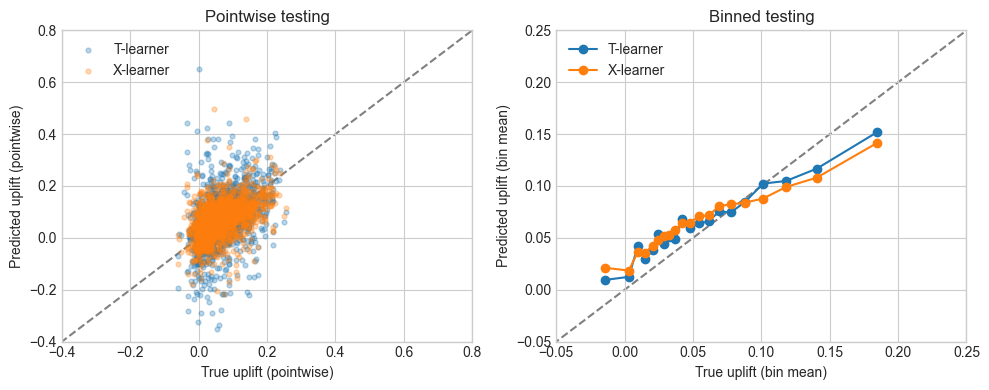

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot
axes[0].scatter(
    uplift["u_true"],
    uplift["tau_T"],
    alpha=0.3,
    s=12,
    label="T-learner",
)
axes[0].scatter(
    uplift["u_true"],
    uplift["tau_X"],
    alpha=0.3,
    s=12,
    label="X-learner",
)
line = np.linspace(-0.6, 0.8, 100)
axes[0].plot(line, line, ls="--", c="gray", lw=1.5, zorder=-2)
axes[0].set_xlabel("True uplift (pointwise)")
axes[0].set_ylabel("Predicted uplift (pointwise)")
axes[0].set_title("Pointwise testing")
axes[0].legend(loc="best")
axes[0].set_xlim([-0.4, 0.8])
axes[0].set_ylim([-0.4, 0.8])


# Plot with shared bins (same groups across models)
cal = binned_validation(
    y_true=uplift["u_true"].values,
    scores={
        "T-learner": uplift["tau_T"].values,
        "X-learner": uplift["tau_X"].values,
    },
    n_bins=20,
)
for name, g in cal.groupby("model"):
    axes[1].plot(g["mean_true"], g["mean_pred"], "o-", label=name)
axes[1].plot(line, line, ls="--", c="gray", lw=1.5, zorder=-2)
axes[1].set_ylabel("Predicted uplift (bin mean)")
axes[1].set_xlabel("True uplift (bin mean)")
axes[1].set_title("Binned testing")
axes[1].legend(loc="best")
axes[1].set_xlim([-0.05, 0.25])
axes[1].set_ylim([-0.05, 0.25])

plt.tight_layout()
plt.show()

In [16]:
# Compute metrics

rmse_T = root_mean_squared_error(uplift["tau_T"], uplift["u_true"])
rmse_X = root_mean_squared_error(uplift["tau_X"], uplift["u_true"])
mae_T = mean_absolute_error(uplift["tau_T"], uplift["u_true"])
mae_X = mean_absolute_error(uplift["tau_X"], uplift["u_true"])
print("RMSE:", f"\nT-learner {rmse_T:.4f}, X-learner: {rmse_X:.4f}")
print("MAE:", f"\nT-learner {mae_T:.4f}, X-learner: {mae_X:.4f}")


RMSE: 
T-learner 0.0812, X-learner: 0.0574
MAE: 
T-learner 0.0529, X-learner: 0.0408


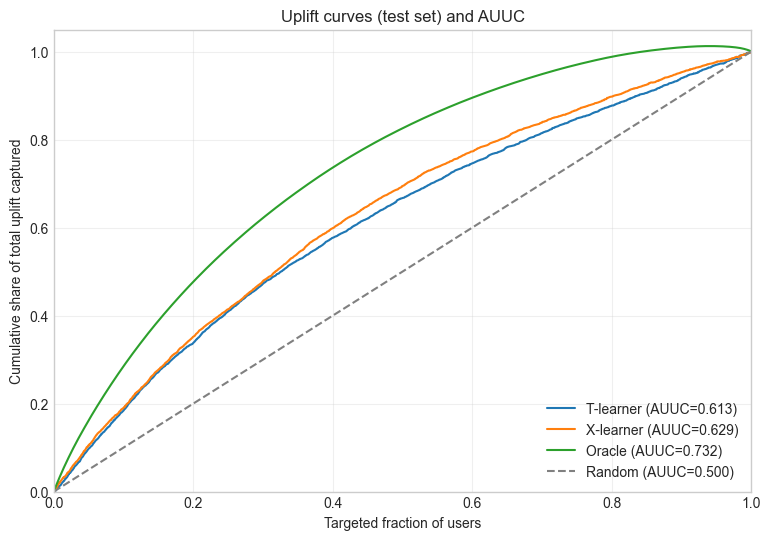

In [22]:
# Curves for each model
f_T, y_T, auuc_T = uplift_curve(u_test, tau_T)
f_X, y_X, auuc_X = uplift_curve(u_test, tau_X)

# Oracle (best possible) and random baselines
f_oracle, y_oracle, auuc_oracle = uplift_curve(u_test, u_test)
# For random, expected share captured equals the targeted fraction
y_rand = np.linspace(0, 1, 200)
auuc_rand = np.trapezoid(y_rand, y_rand)

plt.figure(figsize=(9, 6))
plt.plot(f_T, y_T, label=f"T-learner (AUUC={auuc_T:.3f})", color="C0")
plt.plot(f_X, y_X, label=f"X-learner (AUUC={auuc_X:.3f})", color="C1")
plt.plot(f_oracle, y_oracle, label=f"Oracle (AUUC={auuc_oracle:.3f})", color="C2")
plt.plot(y_rand, y_rand, "--", color="gray", label=f"Random (AUUC={auuc_rand:.3f})")
plt.xlabel("Targeted fraction of users")
plt.ylabel("Cumulative share of total uplift captured")
plt.title("Uplift curves (test set) and AUUC")
plt.legend(loc="lower right")
plt.ylim([min(0, y_T.min(), y_X.min(), y_oracle.min(), 0), 1.05])
plt.xlim([0, 1])
plt.grid(True, alpha=0.3)
plt.show()

### Conclusions

TBW